<a href="https://colab.research.google.com/github/tallpress/fastai/blob/master/moives.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
from fastai.collab import *
from fastai.tabular import *

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
root_path = 'gdrive/My Drive/data/ml-100k'

In [0]:
!cd 'gdrive/My Drive/data/ml-100k' && ls

allbut.pl  u1.base  u2.test  u4.base  u5.test  ub.base	u.genre  u.occupation
mku.sh	   u1.test  u3.base  u4.test  ua.base  ub.test	u.info	 u.user
README	   u2.base  u3.test  u5.base  ua.test  u.data	u.item


In [0]:
ratings = pd.read_csv('gdrive/My Drive/data/ml-100k/u.data',
                      delimiter='\t', header=None, names=['user', 'item', 'rating', 'timestamp'])

In [0]:
ratings.head()

,user,item,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [0]:
movies = pd.read_csv('gdrive/My Drive/data/ml-100k/u.item',
                     delimiter='|', 
                     encoding='latin-1',
                     header=None, 
                     names=['item', 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]])

In [0]:
movies.head()

,item,title,date,N,url,g0,g1,g2,g3,g4,g5,g6,g7,g8,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [0]:
rating_movie = ratings.merge(movies[['item', 'title']])
rating_movie.head()

,user,item,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [0]:
data = CollabDataBunch.from_df(rating_movie, seed=42, valid_pct=0.1, item_name='title')

data.show_batch()

user,title,target
195,"Piano, The (1993)",4.0
145,"Replacement Killers, The (1998)",4.0
639,Field of Dreams (1989),1.0
298,Sleepless in Seattle (1993),5.0
288,"Godfather, The (1972)",5.0


In [0]:
y_range = [0,5.5]
learn = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


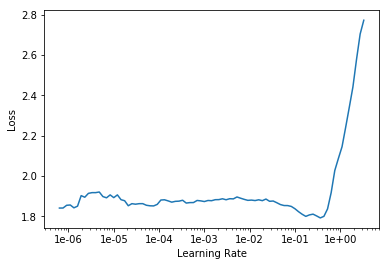

In [0]:
learn.lr_find()
learn.recorder.plot(skip_ends=15)

In [0]:
learn.fit_one_cycle(5, 4e-2)

epoch,train_loss,valid_loss,time
0,1.206127,1.254817,00:09
1,1.351362,1.367252,00:09
2,1.177158,1.143691,00:09
3,0.907609,0.899460,00:09
4,0.678373,0.845135,00:09


In [0]:
learn.fit_one_cycle(5, 2e-2)

epoch,train_loss,valid_loss,time
0,0.794681,0.957410,00:09
1,1.013070,1.020870,00:09
2,0.951376,0.942167,00:09
3,0.780452,0.839578,00:09
4,0.556534,0.833940,00:09


In [0]:
learn.save('dotprod')

~ 48mins

## Interpretation

In [0]:
learn.load('dotprod')
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1654, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
)

In [0]:
all_movies = rating_movie.groupby('title')['rating'].count()
top_movies = all_movies.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)', 'Air Force One (1997)',
       'Independence Day (ID4) (1996)'], dtype=object)

Findind out the bias of the top movies

In [0]:
movie_bias = learn.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [0]:
mean_ratings = rating_movie.groupby('title')['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies, movie_bias)]

In [0]:
item0 = lambda o:o[0]

In [0]:
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.5601),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.5012),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.4886), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.4302), 'Leave It to Beaver (1997)', 1.8409090909090908),
 (tensor(-0.4063), 'Grease 2 (1982)', 2.0),
 (tensor(-0.4017), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.3945), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.3886), 'Free Willy 3: The Rescue (1997)', 1.7407407407407407),
 (tensor(-0.3740), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.3730), 'Showgirls (1995)', 1.9565217391304348),
 (tensor(-0.3700), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.3617), "McHale's Navy (1997)", 2.1884057971014492),
 (tensor(-0.3609), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.3450), "Joe's Apartment (1996)", 2.2444444444444445),
 (tensor(-0.3335), 'Booty Call (1997)', 2.1666

In [0]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.8548), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.8025), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.7817), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.7755), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.7646), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.7598), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.7512), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.7425), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.7139), 'Close Shave, A (1995)', 4.491071428571429),
 (tensor(0.6965), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.6964), 'Godfather, The (1972)', 4.283292978208232),
 (tensor(0.6898), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.6877), "One Flew Over the Cuckoo's Nest (1975)", 4.291666666666667),
 (tensor(0.6809), 'Vertigo (1958)', 4.251396648044692),
 (tensor(0.6724), 'As Good As It Gets (1997)', 4.196428571428571)]

## Movie weights

In [0]:
movie_w = learn.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 40])

pca stands for principle componets analysis. We squish the 40 weights down to 3. Lin trans down from size 40 to 3, does this by finding a similar matrix that covers a similar space. Reduces the number of activations, can be used to make them eaiser to compare by speeding things up. Course - computational linear algebra. Often a good to idea to make comparing inputs eaiser. 

In [0]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [0]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

It is important to note, that we don't know what fac0 is, but we can be sure it is some elemnt of taste/movie feature. So sorting by fac0, we can have a look at what we think it might be, could be movies directed to a younger audience, or more popular easy watching type films. 



In [0]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.1382), 'Jungle2Jungle (1997)'),
 (tensor(1.0669), 'Congo (1995)'),
 (tensor(0.9686), 'D3: The Mighty Ducks (1996)'),
 (tensor(0.8896), 'Speed 2: Cruise Control (1997)'),
 (tensor(0.8530), 'Sliver (1993)'),
 (tensor(0.8451), "Dante's Peak (1997)"),
 (tensor(0.8281), 'Bio-Dome (1996)'),
 (tensor(0.8269), 'First Knight (1995)'),
 (tensor(0.8216), 'Batman & Robin (1997)'),
 (tensor(0.8120), 'Richie Rich (1994)')]

Looking at the other end of the list, we can see that our prediction sort of makes sense, here we get the movies that are typically seen as 'cult movies' loved by those who know their stuff

In [0]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.0430), 'Ran (1985)'),
 (tensor(-1.0057),
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)'),
 (tensor(-0.9967), 'When We Were Kings (1996)'),
 (tensor(-0.9602), 'Chinatown (1974)'),
 (tensor(-0.9400), 'Wrong Trousers, The (1993)'),
 (tensor(-0.9050), 'Lawrence of Arabia (1962)'),
 (tensor(-0.8974), 'Pulp Fiction (1994)'),
 (tensor(-0.8820), 'Close Shave, A (1995)'),
 (tensor(-0.8646), 'Big Sleep, The (1946)'),
 (tensor(-0.8607), 'Paths of Glory (1957)')]

Sorting by fac0, we can see that we get a differnt 'type' of movie, these look like big blockbuster films for all the family

In [0]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

We can plot fac0 and fac1 on a graph to see the relationship between them

[734  23 642 609 167 542 804 666 623 966 233 552 704 965 460 369 146 493 276 142 795 817 230 931 116 554 355 223 854
  15 308 559 847 225 279 237 692 975 171 410 330 784 501 569 153 175 110 576 922 700]


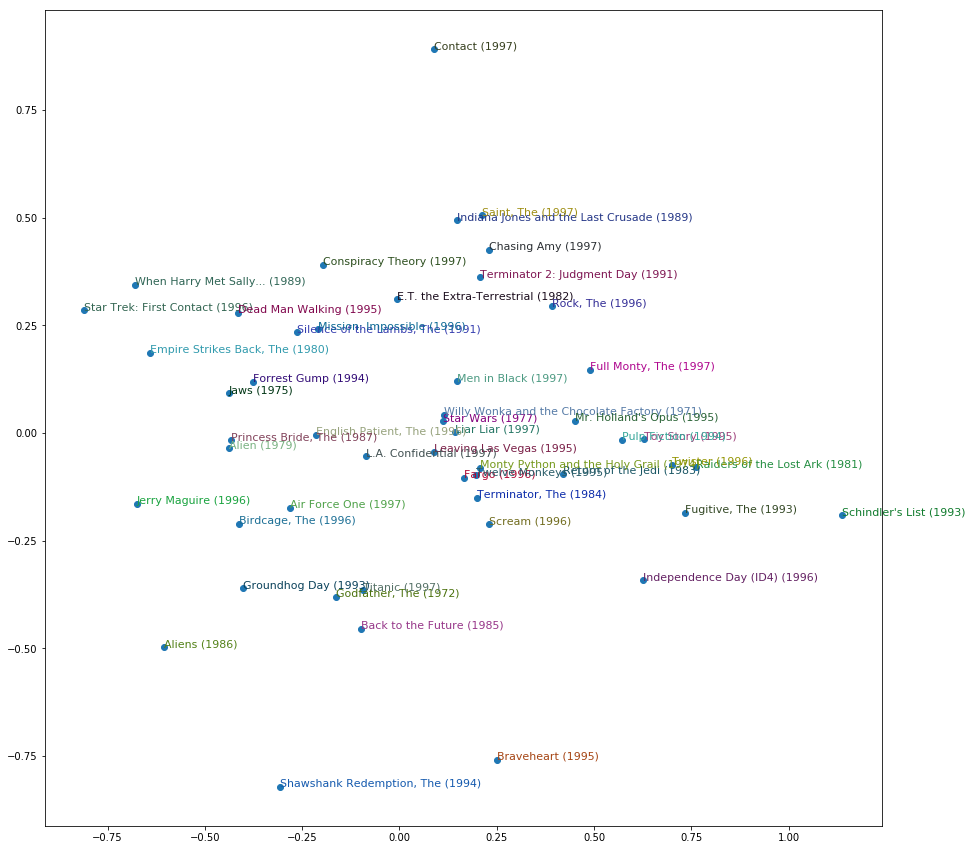

In [0]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
X = fac0[idxs]
Y = fac1[idxs]
idxs = list(range(50))

plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
  n = np.random.rand(3)*0.7
  plt.text(x,y,i, color=n, fontsize=11)
plt.show()

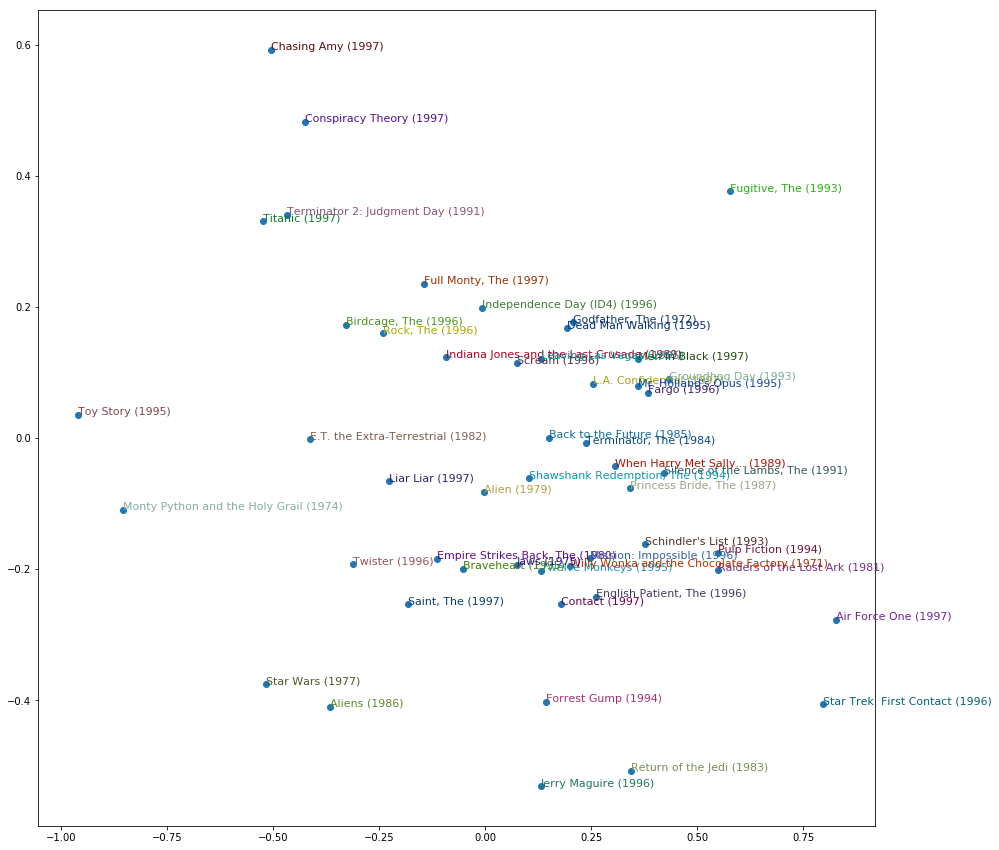

In [0]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
X = fac0[idxs]
Y = fac2[idxs]
idxs = list(range(50))

plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
  n = np.random.rand(3)*0.7
  plt.text(x,y,i, color=n, fontsize=11)
plt.show()